# All Python packages

In [ ]:
!pip3 install numpy
!pip3 install sklearn
!pip3 install scipy
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install keras
!pip3 install mne

     |████████████████████████████████| 462 kB 5.2 MB/s 
     |████████████████████████████████| 7.5 MB 4.3 MB/s 


In [ ]:
!pip install mylib

  Created wheel for mylib: filename=mylib-0.0.1-py3-none-any.whl size=1014 sha256=98116dda1d9150431784413ae74615f29d448087560ff55166621afca161b5c2
  Stored in directory: /root/.cache/pip/wheels/53/50/ab/949c83cdb321ed60fb4cfb4ee5c826f2792f705916eaf76960
Successfully built mylib


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from IPython.utils import io
import numpy as np
import collections

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle

import scipy.io
from scipy import signal, integrate
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout

import mne
import eeg_entropy
import math

n_second = 60
n_segment = 2*n_second-1
n_points = n_second*128
bottleneck = 12

# MinMaxScaler() and (a - min_) / (max_ - min_)

In [ ]:
# build in
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
scaler = MinMaxScaler().fit(a)
a = scaler.transform(a)
print(a)

#custom
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
max_, min_ = np.amax(a), np.amin(a)
a = (a - min_) / (max_ - min_)
print(a)

def normalise_2D(a, multiple):
    max_, min_ = np.amax(a), np.amin(a)
    a = (a - min_) / (max_ - min_)
    return multiple*a

a = np.array([[1,2,3],[4,5,6],[7,8,9]])
normalise_2D(a, 1) # range -10 to 10

[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]
[[0.    0.125 0.25 ]
 [0.375 0.5   0.625]
 [0.75  0.875 1.   ]]


array([[0.   , 0.125, 0.25 ],
       [0.375, 0.5  , 0.625],
       [0.75 , 0.875, 1.   ]])

# StandardScaler() and (a-mean)/std

In [ ]:
# build in
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
scaler = StandardScaler().fit(a)
a = scaler.transform(a)
print(a)

# custom
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
std = np.std(a)
mean = np.mean(a)
a = (a-mean)/std
print(a)

def standardise_2D(a, multiple):
    std = np.std(a)
    mean = np.mean(a)
    a = (a-mean)/std
    return multiple*a

a = np.array([[1,2,3],[4,5,6],[7,8,9]])
standardise_2D(a, 10)

[[-1.22474487 -1.22474487 -1.22474487]
 [ 0.          0.          0.        ]
 [ 1.22474487  1.22474487  1.22474487]]
[[-1.54919334 -1.161895   -0.77459667]
 [-0.38729833  0.          0.38729833]
 [ 0.77459667  1.161895    1.54919334]]


array([[-15.49193338, -11.61895004,  -7.74596669],
       [ -3.87298335,   0.        ,   3.87298335],
       [  7.74596669,  11.61895004,  15.49193338]])

# Convert DEAP dataset from matlab to numpy

In [ ]:
def convertOneData(file_name):
    mat = scipy.io.loadmat(file_name)
    labels = mat['labels'][:, 0:2] # only valence, arousal, no dominance, liking
    data = mat['data'][:, 0:32, 3*128:] # only first 32 channels ['Fp1','AF3','F3','F7','FC5',
    #'FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4',
    #'F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
    #and skip first 3 seconds
    #print(labels.shape, data.shape) # (40, 2) (40, 32, 8064)
    valence_labels, valence_data = [], []
    arousal_labels, arousal_data = [], []
    for i, label in enumerate(labels):
        valence, arousal = label[0], label[1]
        if valence > 5.5: # value >5.5 is high
            valence_labels.append(1)
            valence_data.append(data[i])
        if valence < 4.5: # value <4.5 is high
            valence_labels.append(0)
            valence_data.append(data[i])
        if arousal > 5.5:
            arousal_labels.append(1)
            arousal_data.append(data[i])
        if arousal < 4.5:
            arousal_labels.append(0)
            arousal_data.append(data[i])

    print("valence: ", len(valence_labels), "arousal: ", len(arousal_labels))
    return valence_labels, valence_data, arousal_labels, arousal_data


def convertAllData():
    all_valence_labels, all_valence_data = [], []
    all_arousal_labels, all_arousal_data = [], []
    for i in range(32):
        if i < 10: # subject 01-09
            name = '%0*d' % (2,i+1)
        else: # subject 10-32
            name = i+1
        file_name = "/content/gdrive/MyDrive/TPIB/Dataset/s"+str(name)+".mat"
        print(file_name)
        valence_labels, valence_data, arousal_labels, arousal_data = convertOneData(file_name) # convert one subject data

        all_valence_labels += valence_labels
        for valence_d in valence_data: # each trial
            valence_d = standardise_2D(valence_d, 1)
            all_valence_data.append(valence_d)
        all_arousal_labels += arousal_labels
        for arousal_d in arousal_data:
            arousal_d = standardise_2D(arousal_d, 1)
            all_arousal_data.append(arousal_d)

    all_valence_labels = np.array(all_valence_labels)
    all_valence_data = np.array(all_valence_data)
    all_arousal_labels = np.array(all_arousal_labels)
    all_arousal_data = np.array(all_arousal_data)
    print("Valence trial data for all subject: ", all_valence_labels.shape,all_valence_data.shape)
    print("Arousal trial data for all subject: ", all_arousal_labels.shape,all_arousal_data.shape)
    # save numpy array of total data to files
    np.save('/content/gdrive/MyDrive/TPIB/Dataset/dataProcessed/valence/' + 'all_valence_labels.npy', all_valence_labels)
    np.save('/content/gdrive/MyDrive/TPIB/Dataset/dataProcessed/valence/' + 'all_valence_data.npy', all_valence_data)
    np.save('/content/gdrive/MyDrive/TPIB/Dataset/dataProcessed/arousal/' + 'all_arousal_labels.npy', all_arousal_labels)
    np.save('/content/gdrive/MyDrive/TPIB/Dataset/dataProcessed/arousal/' + 'all_arousal_data.npy', all_arousal_data)

In [ ]:
convertAllData()

/content/gdrive/MyDrive/TPIB/Dataset/s01.mat
valence:  38 arousal:  39
/content/gdrive/MyDrive/TPIB/Dataset/s02.mat
valence:  31 arousal:  34
/content/gdrive/MyDrive/TPIB/Dataset/s03.mat
valence:  27 arousal:  36
/content/gdrive/MyDrive/TPIB/Dataset/s04.mat
valence:  37 arousal:  33
/content/gdrive/MyDrive/TPIB/Dataset/s05.mat
valence:  34 arousal:  31
/content/gdrive/MyDrive/TPIB/Dataset/s06.mat
valence:  33 arousal:  33
/content/gdrive/MyDrive/TPIB/Dataset/s07.mat
valence:  35 arousal:  37
/content/gdrive/MyDrive/TPIB/Dataset/s08.mat
valence:  29 arousal:  27
/content/gdrive/MyDrive/TPIB/Dataset/s09.mat
valence:  30 arousal:  31
/content/gdrive/MyDrive/TPIB/Dataset/s10.mat
valence:  34 arousal:  34
/content/gdrive/MyDrive/TPIB/Dataset/s11.mat
valence:  32 arousal:  34
/content/gdrive/MyDrive/TPIB/Dataset/s12.mat
valence:  34 arousal:  31
/content/gdrive/MyDrive/TPIB/Dataset/s13.mat
valence:  33 arousal:  37
/content/gdrive/MyDrive/TPIB/Dataset/s14.mat
valence:  40 arousal:  40
/conte

# Load np data and balance high and low label

In [ ]:
def load_np_data(dimension):
    if dimension == 'valence':
        all_labels, all_data = np.load('/content/gdrive/MyDrive/TPIB/Dataset/dataProcessed/valence/' + 'all_valence_labels.npy', allow_pickle=True), np.load('/content/gdrive/MyDrive/TPIB/Dataset/dataProcessed/valence/' + 'all_valence_data.npy', allow_pickle=True)
        print("Total valence: ", all_labels.shape, all_data.shape)
        #print("High and low valence: ", collections.Counter(all_labels))# 587 high valence, 472 low valence
    elif dimension == 'arousal':
        all_labels, all_data = np.load('/content/gdrive/MyDrive/TPIB/Dataset/dataProcessed/arousal/' + 'all_arousal_labels.npy', allow_pickle=True), np.load('/content/gdrive/MyDrive/TPIB/Dataset/dataProcessed/arousal/' + 'all_arousal_data.npy', allow_pickle=True)
        print("Total arousal: ", all_labels.shape, all_data.shape)
        #print("High and low arousal: ", collections.Counter(all_labels))# 620 high arousal, 462 low arousal
    return all_labels, all_data

In [ ]:
#all_labels, all_data = load_np_data(dimension="valence")
all_labels, all_data = load_np_data(dimension="arousal")

In [ ]:
# after standardised
print(np.amax(all_data)) # max value
print(np.amin(all_data)) # min value

# print(np.amax(all_valence_data[0])) # max value
# print(np.amin(all_valence_data[0])) # min value

64.64274117928039
-84.21760335739728


# Feature extraction method (Power)

In [ ]:
def trial_psd_extraction_integration(data): # data shape (12, 8064)
    info = mne.create_info(ch_names= ['1','2','3','4','5','6','7','8','9','10','11','12'], sfreq=128);
    raw = mne.io.RawArray(data, info, first_samp=0, copy='auto', verbose=None);
    psd_origin, f = mne.time_frequency.psd_welch(raw, fmin=0, fmax=60, n_fft=128, n_overlap=64, n_per_seg=128, picks='all', window='hann', average=None, verbose=None)# average='mean' or None
    # print(psd_origin.shape, f.shape) # (12, 61, 125) (61,) 61 frequency
    psd = np.moveaxis(psd_origin, -1, 0) # (125, 12, 61)
    # calculate frequency band power using integration
    band_power = [] # band power for all segments
    for segment in psd:
        segment_band_power = [] # band power for all channels in one segment
        for psd_channel in segment:
            y_int = integrate.cumtrapz(psd_channel, f, initial=0) # integrate to calculate band power
            one_band_power = np.array([y_int[7]-y_int[4],y_int[13]-y_int[8],y_int[30]-y_int[14],y_int[51]-y_int[31]])
            segment_band_power.append(one_band_power)
        band_power.append(segment_band_power)
    band_power = np.array(band_power) # (125, 12, 4)
    band_power = np.moveaxis(band_power, -1, 1) # (125, 4, 12)
    band_power = band_power.reshape((n_segment, bottleneck*4)) # flatten feature (125, 48)
    band_power = 10*band_power
    return band_power


# 10-fold cross-validation

In [ ]:
# change dimension from (849, 32, 7680)to (849, 8064, 32) then to (6846336, 32) for input 32-dimension vector to autoencoder
def vector_transform(data):
    vectors = np.moveaxis(data, 1, -1)
    vectors = vectors.reshape((vectors.shape[0]*vectors.shape[1], vectors.shape[2]))
    return vectors

# change output of autoencoder dimension from (6846336, 12) to (849, 8064, 12) then to (849, 12, 8064)
def inverse_vector_transform(vectors):
    data = vectors.reshape((int(vectors.shape[0]/n_points), n_points, vectors.shape[1]))
    data = np.moveaxis(data, -1, 1)
    return data

In [ ]:
all_data, all_labels = shuffle(all_data, all_labels, random_state=0)
n = len(all_labels) # 1059
print(n)
fold_n = math.floor(n/10) # 105
print(fold_n)
all_data, all_labels = all_data[:10*fold_n], all_labels[:10*fold_n] # (1050, 32, 8064)
print(all_data.shape)

1082
108
(1080, 32, 7680)


In [ ]:
def process(test_fold_number):
    # train has 9 folds, test has 1 fold
    train_data = np.concatenate((all_data[:test_fold_number*fold_n], all_data[fold_n+test_fold_number*fold_n:]), axis=0)
    train_labels = np.concatenate((all_labels[:test_fold_number*fold_n], all_labels[fold_n+test_fold_number*fold_n:]), axis=0)
    test_data = all_data[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
    test_labels = all_labels[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
    print(train_data.shape,test_data.shape) # (945, 32, 8064) (105, 32, 8064)

    # change dimension to 32-dimension vector for input to autoencoder
    train_vectors = vector_transform(train_data)
    test_vectors = vector_transform(test_data)
    print(train_vectors.shape, test_vectors.shape)# (7620480, 32) (846720, 32)

    # -------- Create new autoencoder --------
    input_layer = Input(shape=(32,))
    encoded = Dense(64, activation=None)(input_layer)
    bottleneck_layer = Dense(bottleneck, activation=None)(encoded)
    decoded = Dense(64, activation=None)(bottleneck_layer)
    decoded = Dense(32, activation=None)(decoded)
    autoencoder = Model(input_layer, decoded)
    #autoencoder.summary()

    encoder = Model(input_layer, bottleneck_layer)
    #encoder.summary()

    decoder_input_layer = Input(shape=(bottleneck,))
    decoder_layer = autoencoder.layers[-2](decoder_input_layer)
    decoder_layer = autoencoder.layers[-1](decoder_layer)
    decoder = Model(decoder_input_layer, decoder_layer)
    #decoder.summary()

    # -------- Compile and train autoencoder --------
    autoencoder.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    autoencoder.fit(train_vectors, train_vectors, epochs=1, batch_size=64, shuffle=True, validation_data=(test_vectors, test_vectors))
    autoencoder.save("/content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_" + str(test_fold_number))

    # -------- Encode train and test data by pass through encoder --------
    train_data_encoded = encoder.predict(train_vectors)
    train_data_encoded = inverse_vector_transform(train_data_encoded)
    test_data_encoded = encoder.predict(test_vectors)
    test_data_encoded = inverse_vector_transform(test_data_encoded)
    print("Encoded training data shape: ", train_data_encoded.shape)
    print("Encoded test data shape: ", test_data_encoded.shape)

    # -------- Feature extraction from 12 source signal --------
    train_band_power = [] # band power feature sequence for train trials
    for data in train_data_encoded: # for every train trial
        with io.capture_output() as captured:
            trial_band_power = trial_psd_extraction_integration(data) # data shape (12, 8064)
        train_band_power.append(trial_band_power)
    train_band_power = np.array(train_band_power)

    test_band_power = [] # band power feature sequence for test trials
    for data in test_data_encoded: # for every test trial
        with io.capture_output() as captured:
            trial_band_power = trial_psd_extraction_integration(data) # data shape (12, 8064)
        test_band_power.append(trial_band_power)
    test_band_power = np.array(test_band_power)
    print("All features of training data shape: ", train_band_power.shape) # shape (849, 125, 48)
    print("All features of test data shape: ", test_band_power.shape) # shape (95, 125, 48)

    # -------- Create new LSTM model --------
    x=Input(shape=(n_segment,bottleneck*4)) # flatten (12,4) to 48
    x1=LSTM(n_segment)(x)
    x2=Dense(n_segment)(x1)
    x3=Dense(12)(x2)
    output=Dense(1, activation="sigmoid")(x2)
    model=Model(x, output)

    # -------- Compile and train LSTM --------
    model.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    history = model.fit(train_band_power, train_labels, epochs=30, batch_size=8, validation_data=(test_band_power, test_labels))
    print("Hightest accuracy: " + str(max(history.history['val_accuracy'])))
    model.save("/content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_" + str(test_fold_number))


In [ ]:
for i in range(10):
    print("********** Test Fold " + str(i) + " ************")
    process(i)

********** Test Fold 0 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 219s 2ms/step - loss: 0.2256 - accuracy: 0.4577 - val_loss: 0.2241 - val_accuracy: 0.4566
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_0/assets
Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 12s 77ms/step - loss: 0.2513 - accuracy: 0.5535 - val_loss: 0.2409 - val_accuracy: 0.5741
Epoch 2/30
122/122 [==============================] - 9s 72ms/step - loss: 0.2303 - accuracy: 0.6204 - val_loss: 0.2327 - val_accuracy: 0.6019
Epoch 3/30
122/122 [==============================] - 8s 68ms/step - loss: 0.2186 - accuracy: 0.6430 - val_loss: 0.2300 - val_accuracy: 0.5741
Epoch 4/30
1

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_0/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_0/assets


********** Test Fold 1 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 207s 2ms/step - loss: 0.2262 - accuracy: 0.4539 - val_loss: 0.2195 - val_accuracy: 0.4613
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_1/assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 11s 74ms/step - loss: 0.2454 - accuracy: 0.5710 - val_loss: 0.2533 - val_accuracy: 0.5556
Epoch 2/30
122/122 [==============================] - 8s 70ms/step - loss: 0.2278 - accuracy: 0.6132 - val_loss: 0.2543 - val_accuracy: 0.6111
Epoch 3/30
122/122 [==============================] - 8s 68ms/step - loss: 0.2176 - accuracy: 0.6492 - val_loss: 0.2504 - val_accuracy: 0.6019
Epoch 4/30
122/122 [==============================] - 8s 70ms/step - loss: 0.2109 - accuracy: 0.6708 - val_loss: 0.2527 - val_accuracy: 0.5926
Epoch 5/30
122/122 [==============================] - 8s 69ms/step - loss: 0.2049 - accuracy: 0.6944 - val_loss: 0.2482 - val_accuracy: 0.6204
Epoch 6/30
122/122 [==============================] - 8s 69ms/step - loss: 0.1994 - accuracy: 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_1/assets


********** Test Fold 2 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 203s 2ms/step - loss: 0.2250 - accuracy: 0.4576 - val_loss: 0.2265 - val_accuracy: 0.4476
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_2/assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 11s 74ms/step - loss: 0.2530 - accuracy: 0.5226 - val_loss: 0.2376 - val_accuracy: 0.5463
Epoch 2/30
122/122 [==============================] - 8s 70ms/step - loss: 0.2302 - accuracy: 0.6265 - val_loss: 0.2287 - val_accuracy: 0.6111
Epoch 3/30
122/122 [==============================] - 9s 70ms/step - loss: 0.2200 - accuracy: 0.6553 - val_loss: 0.2255 - val_accuracy: 0.6574
Epoch 4/30
122/122 [==============================] - 9s 71ms/step - loss: 0.2143 - accuracy: 0.6615 - val_loss: 0.2235 - val_accuracy: 0.6574
Epoch 5/30
122/122 [==============================] - 9s 71ms/step - loss: 0.2072 - accuracy: 0.6821 - val_loss: 0.2213 - val_accuracy: 0.5926
Epoch 6/30
122/122 [==============================] - 9s 71ms/step - loss: 0.2038 - accuracy: 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_2/assets


********** Test Fold 3 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 211s 2ms/step - loss: 0.2268 - accuracy: 0.4530 - val_loss: 0.2297 - val_accuracy: 0.4443
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_3/assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 12s 80ms/step - loss: 0.2451 - accuracy: 0.5648 - val_loss: 0.2446 - val_accuracy: 0.6019
Epoch 2/30
122/122 [==============================] - 9s 70ms/step - loss: 0.2297 - accuracy: 0.6265 - val_loss: 0.2344 - val_accuracy: 0.6204
Epoch 3/30
122/122 [==============================] - 9s 71ms/step - loss: 0.2212 - accuracy: 0.6348 - val_loss: 0.2365 - val_accuracy: 0.6019
Epoch 4/30
122/122 [==============================] - 9s 71ms/step - loss: 0.2133 - accuracy: 0.6862 - val_loss: 0.2344 - val_accuracy: 0.6296
Epoch 5/30
122/122 [==============================] - 9s 71ms/step - loss: 0.2076 - accuracy: 0.6965 - val_loss: 0.2344 - val_accuracy: 0.6296
Epoch 6/30
122/122 [==============================] - 9s 70ms/step - loss: 0.2018 - accuracy: 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_3/assets


********** Test Fold 4 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 220s 2ms/step - loss: 0.2234 - accuracy: 0.4602 - val_loss: 0.2402 - val_accuracy: 0.4297
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_4/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_4/assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 13s 88ms/step - loss: 0.2536 - accuracy: 0.5381 - val_loss: 0.2431 - val_accuracy: 0.5556
Epoch 2/30
122/122 [==============================] - 9s 74ms/step - loss: 0.2309 - accuracy: 0.6060 - val_loss: 0.2394 - val_accuracy: 0.6111
Epoch 3/30
122/122 [==============================] - 10s 79ms/step - loss: 0.2187 - accuracy: 0.6502 - val_loss: 0.2404 - val_accuracy: 0.5741
Epoch 4/30
122/122 [==============================] - 9s 72ms/step - loss: 0.2116 - accuracy: 0.6718 - val_loss: 0.2353 - val_accuracy: 0.6019
Epoch 5/30
122/122 [==============================] - 9s 73ms/step - loss: 0.2062 - accuracy: 0.6893 - val_loss: 0.2321 - val_accuracy: 0.6204
Epoch 6/30
122/122 [==============================] - 9s 74ms/step - loss: 0.2014 - accuracy:

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_4/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_4/assets


********** Test Fold 5 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 216s 2ms/step - loss: 0.2257 - accuracy: 0.4596 - val_loss: 0.2209 - val_accuracy: 0.4499
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_5/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_5/assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 12s 83ms/step - loss: 0.2530 - accuracy: 0.5195 - val_loss: 0.2341 - val_accuracy: 0.5926
Epoch 2/30
122/122 [==============================] - 10s 78ms/step - loss: 0.2291 - accuracy: 0.6430 - val_loss: 0.2248 - val_accuracy: 0.6481
Epoch 3/30
122/122 [==============================] - 10s 85ms/step - loss: 0.2170 - accuracy: 0.6800 - val_loss: 0.2270 - val_accuracy: 0.6111
Epoch 4/30
122/122 [==============================] - 10s 79ms/step - loss: 0.2098 - accuracy: 0.6944 - val_loss: 0.2221 - val_accuracy: 0.6574
Epoch 5/30
122/122 [==============================] - 10s 78ms/step - loss: 0.2044 - accuracy: 0.7119 - val_loss: 0.2218 - val_accuracy: 0.6481
Epoch 6/30
122/122 [==============================] - 9s 77ms/step - loss: 0.1984 - accura

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_5/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_5/assets


********** Test Fold 6 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 224s 2ms/step - loss: 0.2273 - accuracy: 0.4496 - val_loss: 0.2063 - val_accuracy: 0.4967
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_6/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_6/assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 13s 87ms/step - loss: 0.2495 - accuracy: 0.5453 - val_loss: 0.2536 - val_accuracy: 0.5463
Epoch 2/30
122/122 [==============================] - 10s 78ms/step - loss: 0.2238 - accuracy: 0.6451 - val_loss: 0.2475 - val_accuracy: 0.5278
Epoch 3/30
122/122 [==============================] - 10s 80ms/step - loss: 0.2126 - accuracy: 0.6739 - val_loss: 0.2369 - val_accuracy: 0.6204
Epoch 4/30
122/122 [==============================] - 9s 77ms/step - loss: 0.2068 - accuracy: 0.6965 - val_loss: 0.2413 - val_accuracy: 0.6019
Epoch 5/30
122/122 [==============================] - 10s 78ms/step - loss: 0.2017 - accuracy: 0.6996 - val_loss: 0.2452 - val_accuracy: 0.5833
Epoch 6/30
122/122 [==============================] - 10s 83ms/step - loss: 0.1965 - accura

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_6/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_6/assets


********** Test Fold 7 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 320s 3ms/step - loss: 0.2255 - accuracy: 0.4556 - val_loss: 0.2198 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_7/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_7/assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 26s 157ms/step - loss: 0.2514 - accuracy: 0.5535 - val_loss: 0.2432 - val_accuracy: 0.6204
Epoch 2/30
122/122 [==============================] - 19s 155ms/step - loss: 0.2319 - accuracy: 0.6214 - val_loss: 0.2276 - val_accuracy: 0.6944
Epoch 3/30
122/122 [==============================] - 22s 184ms/step - loss: 0.2226 - accuracy: 0.6564 - val_loss: 0.2328 - val_accuracy: 0.6389
Epoch 4/30
122/122 [==============================] - 19s 157ms/step - loss: 0.2147 - accuracy: 0.6862 - val_loss: 0.2236 - val_accuracy: 0.7130
Epoch 5/30
122/122 [==============================] - 15s 127ms/step - loss: 0.2093 - accuracy: 0.6965 - val_loss: 0.2214 - val_accuracy: 0.6852
Epoch 6/30
122/122 [==============================] - 17s 142ms/step - loss: 0.2031 -

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_7/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_7/assets


********** Test Fold 8 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 295s 3ms/step - loss: 0.2251 - accuracy: 0.4572 - val_loss: 0.2312 - val_accuracy: 0.4533
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_8/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_8/assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 12s 78ms/step - loss: 0.2488 - accuracy: 0.5628 - val_loss: 0.2602 - val_accuracy: 0.5185
Epoch 2/30
122/122 [==============================] - 9s 74ms/step - loss: 0.2214 - accuracy: 0.6595 - val_loss: 0.2586 - val_accuracy: 0.5185
Epoch 3/30
122/122 [==============================] - 8s 70ms/step - loss: 0.2132 - accuracy: 0.6687 - val_loss: 0.2605 - val_accuracy: 0.5556
Epoch 4/30
122/122 [==============================] - 9s 72ms/step - loss: 0.2050 - accuracy: 0.7027 - val_loss: 0.2638 - val_accuracy: 0.5278
Epoch 5/30
122/122 [==============================] - 9s 71ms/step - loss: 0.1988 - accuracy: 0.7274 - val_loss: 0.2614 - val_accuracy: 0.5741
Epoch 6/30
122/122 [==============================] - 9s 74ms/step - loss: 0.1918 - accuracy: 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_8/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_8/assets


********** Test Fold 9 ************
(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)
116640/116640 [==============================] - 233s 2ms/step - loss: 0.2238 - accuracy: 0.4559 - val_loss: 0.2393 - val_accuracy: 0.4675
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_9/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_9/assets


Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)
All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)
Epoch 1/30
122/122 [==============================] - 11s 76ms/step - loss: 0.2490 - accuracy: 0.5720 - val_loss: 0.2297 - val_accuracy: 0.6667
Epoch 2/30
122/122 [==============================] - 9s 72ms/step - loss: 0.2305 - accuracy: 0.6132 - val_loss: 0.2305 - val_accuracy: 0.6481
Epoch 3/30
122/122 [==============================] - 9s 72ms/step - loss: 0.2210 - accuracy: 0.6327 - val_loss: 0.2272 - val_accuracy: 0.6667
Epoch 4/30
122/122 [==============================] - 9s 73ms/step - loss: 0.2157 - accuracy: 0.6636 - val_loss: 0.2261 - val_accuracy: 0.6574
Epoch 5/30
122/122 [==============================] - 9s 72ms/step - loss: 0.2094 - accuracy: 0.6728 - val_loss: 0.2235 - val_accuracy: 0.6759
Epoch 6/30
122/122 [==============================] - 9s 72ms/step - loss: 0.2045 - accuracy: 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_9/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/LSTM_model/LSTM_model_test_fold_9/assets


# Test each section in process() function

In [ ]:
test_fold_number = 0
# train has 9 folds, test has 1 fold
train_data = np.concatenate((all_data[:test_fold_number*fold_n], all_data[fold_n+test_fold_number*fold_n:]), axis=0)
train_labels = np.concatenate((all_labels[:test_fold_number*fold_n], all_labels[fold_n+test_fold_number*fold_n:]), axis=0)
test_data = all_data[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
test_labels = all_labels[test_fold_number*fold_n : fold_n+test_fold_number*fold_n]
print(train_data.shape,test_data.shape) # (945, 32, 8064) (105, 32, 8064)

# change dimension to 32-dimension vector for input to autoencoder
train_vectors = vector_transform(train_data)
test_vectors = vector_transform(test_data)
print(train_vectors.shape, test_vectors.shape)# (7620480, 32) (846720, 32)

(972, 32, 7680) (108, 32, 7680)
(7464960, 32) (829440, 32)


In [ ]:
# -------- Create new autoencoder --------
input_layer = Input(shape=(32,))
encoded = Dense(64, activation=None)(input_layer)
bottleneck_layer = Dense(bottleneck, activation=None)(encoded)
decoded = Dense(64, activation=None)(bottleneck_layer)
decoded = Dense(32, activation=None)(decoded)
autoencoder = Model(input_layer, decoded)
#autoencoder.summary()

encoder = Model(input_layer, bottleneck_layer)
#encoder.summary()

decoder_input_layer = Input(shape=(bottleneck,))
decoder_layer = autoencoder.layers[-2](decoder_input_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(decoder_input_layer, decoder_layer)
#decoder.summary()

# -------- Compile and train autoencoder --------
autoencoder.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
autoencoder.fit(train_vectors, train_vectors, epochs=1, batch_size=64, shuffle=True, validation_data=(test_vectors, test_vectors))
autoencoder.save("/content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_" + str(test_fold_number))

116640/116640 [==============================] - 254s 2ms/step - loss: 0.2252 - accuracy: 0.4577 - val_loss: 0.2240 - val_accuracy: 0.4554
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_0/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_0/assets


In [ ]:
# -------- Encode train and test data by pass through encoder --------
train_data_encoded = encoder.predict(train_vectors)
train_data_encoded = inverse_vector_transform(train_data_encoded)
test_data_encoded = encoder.predict(test_vectors)
test_data_encoded = inverse_vector_transform(test_data_encoded)
print("Encoded training data shape: ", train_data_encoded.shape) # (945, 12, 8064)
print("Encoded test data shape: ", test_data_encoded.shape) # (105, 12, 8064)

Encoded training data shape:  (972, 12, 7680)
Encoded test data shape:  (108, 12, 7680)


In [ ]:
# -------- Feature extraction from 12 source signal --------
train_band_power = [] # band power feature sequence for train trials
for data in train_data_encoded: # for every train trial
    with io.capture_output() as captured:
        trial_band_power = trial_psd_extraction_integration(data) # data shape (12, 8064)
    train_band_power.append(trial_band_power)
train_band_power = np.array(train_band_power)

test_band_power = [] # band power feature sequence for test trials
for data in test_data_encoded: # for every test trial
    with io.capture_output() as captured:
        trial_band_power = trial_psd_extraction_integration(data) # data shape (12, 8064)
    test_band_power.append(trial_band_power)
test_band_power = np.array(test_band_power)
print("All features of training data shape: ", train_band_power.shape) # shape (849, 125, 48)
print("All features of test data shape: ", test_band_power.shape) # shape (95, 125, 48)

All features of training data shape:  (972, 119, 48)
All features of test data shape:  (108, 119, 48)


In [ ]:
# -------- Create new LSTM model --------
x=Input(shape=(n_segment,bottleneck*4)) # flatten (12,4) to 48
x1=LSTM(n_segment)(x)
x2=Dense(n_segment)(x1)
x3=Dense(12)(x2)
output=Dense(1, activation="sigmoid")(x2)
model=Model(x, output)

# -------- Compile and train LSTM --------
model.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
model.fit(train_band_power, train_labels, epochs=30, batch_size=8, validation_data=(test_band_power, test_labels))
model.save("/content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_" + str(test_fold_number))

Epoch 1/30
122/122 [==============================] - 10s 70ms/step - loss: 0.2413 - accuracy: 0.5802 - val_loss: 0.2423 - val_accuracy: 0.5741
Epoch 2/30
122/122 [==============================] - 8s 68ms/step - loss: 0.2253 - accuracy: 0.6337 - val_loss: 0.2347 - val_accuracy: 0.6111
Epoch 3/30
122/122 [==============================] - 8s 68ms/step - loss: 0.2164 - accuracy: 0.6626 - val_loss: 0.2307 - val_accuracy: 0.6296
Epoch 4/30
122/122 [==============================] - 8s 67ms/step - loss: 0.2087 - accuracy: 0.6842 - val_loss: 0.2286 - val_accuracy: 0.6481
Epoch 5/30
122/122 [==============================] - 9s 71ms/step - loss: 0.2029 - accuracy: 0.6893 - val_loss: 0.2211 - val_accuracy: 0.6574
Epoch 6/30
122/122 [==============================] - 8s 69ms/step - loss: 0.1980 - accuracy: 0.7140 - val_loss: 0.2217 - val_accuracy: 0.6759
Epoch 7/30
122/122 [==============================] - 8s 69ms/step - loss: 0.1949 - accuracy: 0.7191 - val_loss: 0.2168 - val_accuracy: 0.694

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_0/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_0/assets


# Visualize source signals

Creating RawArray with float64 data, n_channels=12, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Using matplotlib as 2D backend.
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


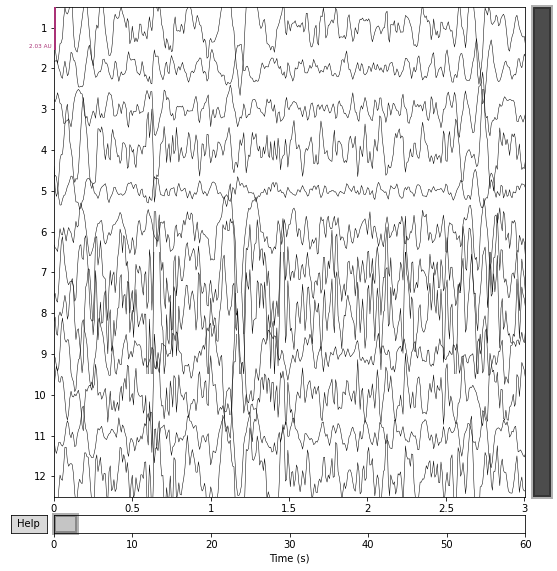

In [ ]:
# extract feature from 12-channel source signal
data = train_data_encoded[0]
info = mne.create_info(ch_names= ['1','2','3','4','5','6','7','8','9','10','11','12',], sfreq=128)
raw = mne.io.RawArray(data, info, first_samp=0, copy='auto', verbose=None)
raw.plot(duration=3, n_channels=12);

Effective window size : 1.000 (s)
(12, 61, 119) (61,)


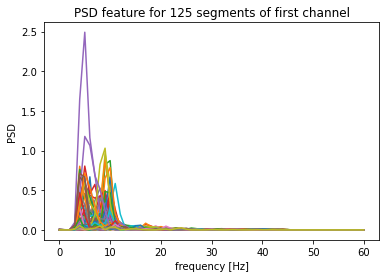

In [ ]:
# calculate PSD of all channels using welch method
psd_origin, f = mne.time_frequency.psd_welch(raw, fmin=0, fmax=60, n_fft=128, n_overlap=64, n_per_seg=128, picks='all', window='hann', average=None, verbose=None)# average='mean' or None
print(psd_origin.shape, f.shape) # (12, 61, 125) (61,)
plt.plot(f, psd_origin[0]) # first channel psd of 125 segments
plt.title("PSD feature for 125 segments of first channel")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

In [ ]:
trial_psd_extraction_integration(train_data_encoded[0])

Creating RawArray with float64 data, n_channels=12, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Effective window size : 1.000 (s)


array([[1.54541336, 0.42569691, 0.53171542, ..., 2.74683403, 0.27114329,
        2.55128914],
       [8.46963919, 1.04124246, 0.4284993 , ..., 0.88158554, 0.10777615,
        0.8846551 ],
       [2.119757  , 0.46243511, 0.24923384, ..., 1.3414896 , 0.15541819,
        1.29276311],
       ...,
       [0.29713427, 0.19646632, 0.36086951, ..., 2.37839855, 0.11503154,
        2.51207283],
       [0.63413511, 0.04960089, 0.34729522, ..., 1.48310049, 0.05324298,
        1.66520235],
       [0.58843693, 0.04777056, 0.30567251, ..., 2.60181128, 0.22828273,
        1.4539663 ]])

# Load one subject data to test

In [ ]:
mat = scipy.io.loadmat('/content/gdrive/MyDrive/TPIB/Dataset/s01.mat')
data = mat['data'][:, 0:32, 3*128:] # only first 32 channels ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']

one_data = data[0]

# change to mne format # system used in DEAP 'biosemi32'
biosemi32 = mne.channels.make_standard_montage('biosemi32')
info = mne.create_info(ch_names=biosemi32.ch_names, ch_types='eeg', sfreq=128)
raw = mne.EvokedArray(one_data, info) # first trial evoked data

print(data.shape)
print(np.amax(data)) # max value
print(np.amin(data)) # min value

(40, 32, 7680)
126.13356159993128
-93.12451745086868


Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


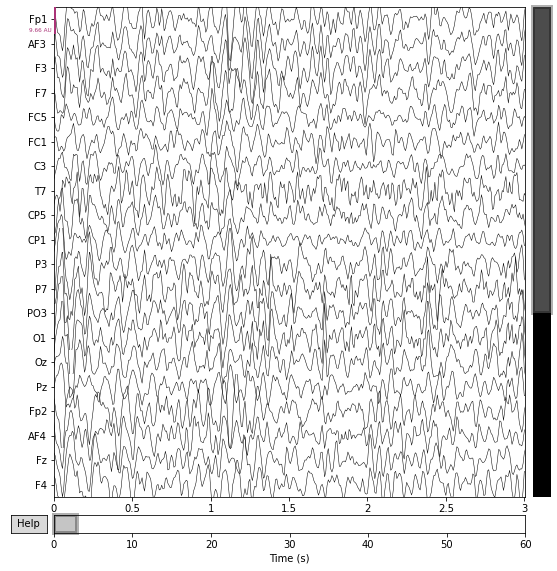

In [ ]:
info_ = mne.create_info(ch_names= ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2'], sfreq=128)
raw_ = mne.io.RawArray(one_data, info_, first_samp=0, copy='auto', verbose=None);
raw_.plot(duration=3, n_channels=20);

# Visaulise electrodes position

Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


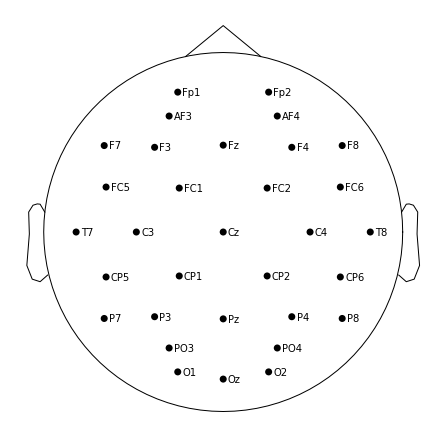

In [ ]:
# fig = biosemi32.plot(kind='3d')
# fig.gca().view_init(azim=70, elev=15)
biosemi32.plot(kind='topomap', show_names=True);

# Visaulise colormap

(<matplotlib.image.AxesImage at 0x7f9b92e31710>,
 <matplotlib.contour.QuadContourSet at 0x7f9b92e31890>)

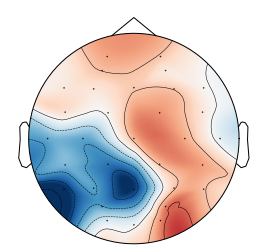

In [ ]:
raw = raw.set_montage(biosemi32)
mne.viz.plot_topomap(raw.data[:, 0], raw.info, show=False) # time step 0

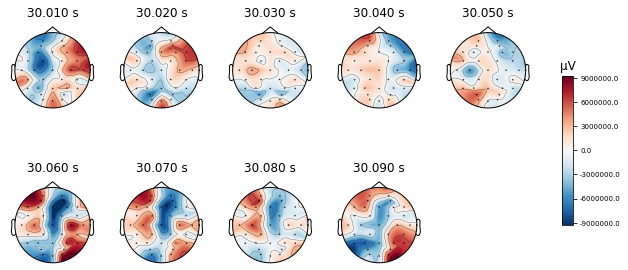

In [ ]:
times = np.arange(30.01, 30.10, 0.01) # from 30s to 30.2s
raw.plot_topomap(times, ch_type='eeg', time_unit='s', ncols=5, nrows='auto');

# Compare original and standardized signal

In [ ]:
standardised_data = standardise_2D(one_data, 1)

print(np.amax(one_data)) # max value
print(np.amin(one_data)) # min value
print(np.amax(standardised_data)) # max value
print(np.amin(standardised_data)) # min value

33.46697829071114
-31.335874596603272
8.3196132436574
-7.789838539676193


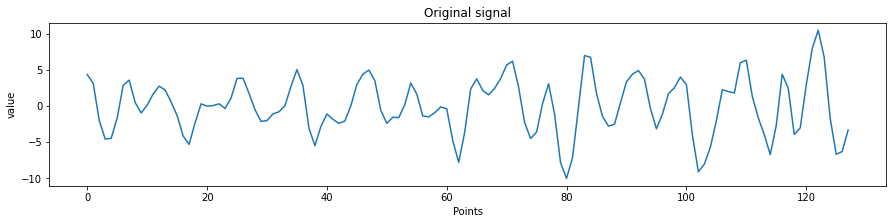

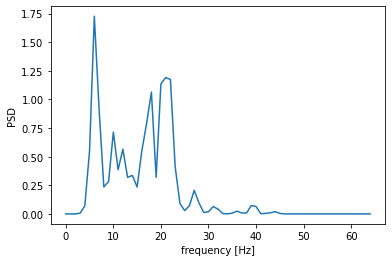

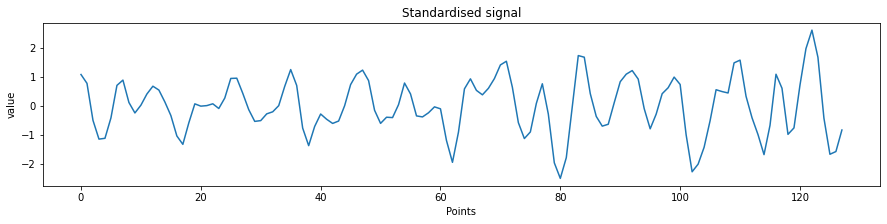

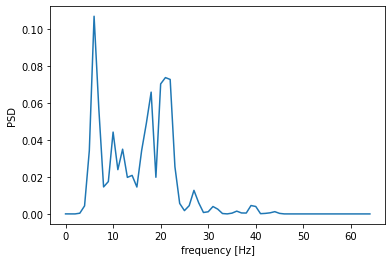

[ 43.90840737 105.68757443 213.48566124  64.13231123]


In [ ]:
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(one_data[0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(one_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(standardised_data[0][nth*128:nth*128+128])
plt.title("Standardised signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(standardised_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

channel_psd, channel_psd2 = eeg_entropy.bin_power(standardised_data[0][nth*128:nth*128+128], [4,7.5,13.5,30.5,50], Fs=128)
print(channel_psd)

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


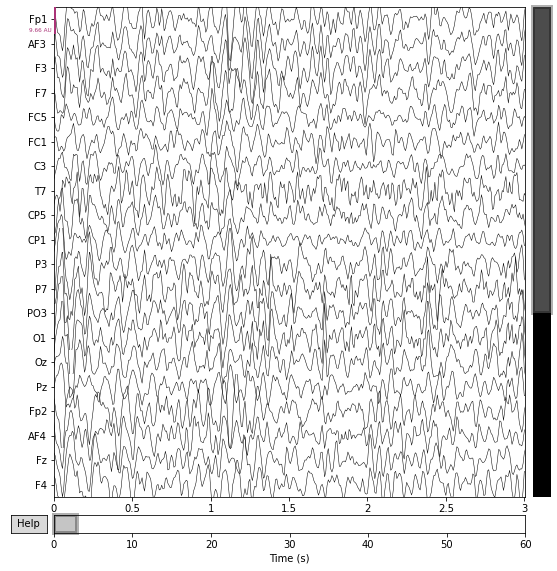

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


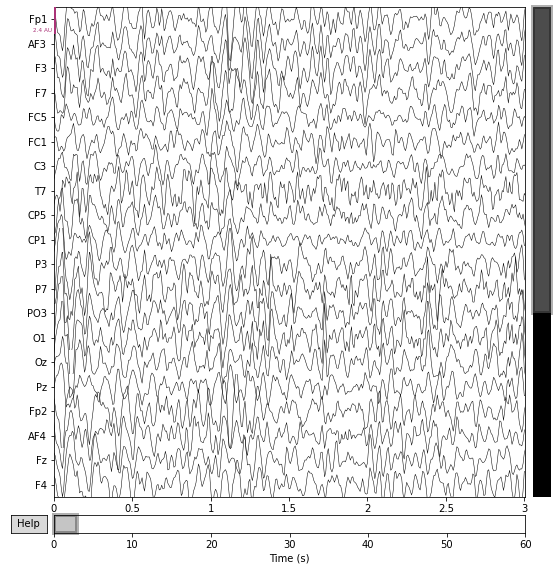

In [ ]:
info2 = mne.create_info(ch_names= ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2'], sfreq=128)
raw2 = mne.io.RawArray(one_data, info2, first_samp=0, copy='auto', verbose=None);
raw2.plot(duration=3, n_channels=20);

stanardised_raw2 = mne.io.RawArray(standardised_data, info2, first_samp=0, copy='auto', verbose=None);
stanardised_raw2.plot(duration=3, n_channels=20);

# Compare original and normalised signal

In [ ]:
def normalise_2D(a, multiple):
    max_, min_ = np.amax(a), np.amin(a)
    a = (a - min_) / (max_ - min_)
    return multiple*a

normalised_data = normalise_2D(one_data, 1)

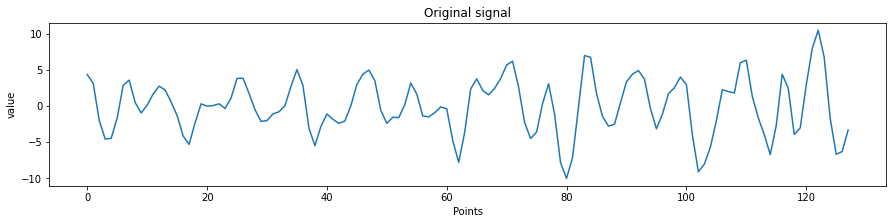

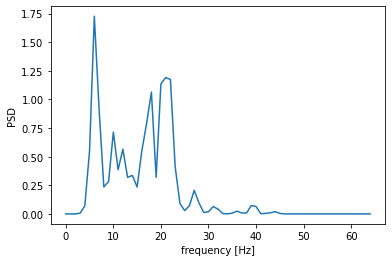

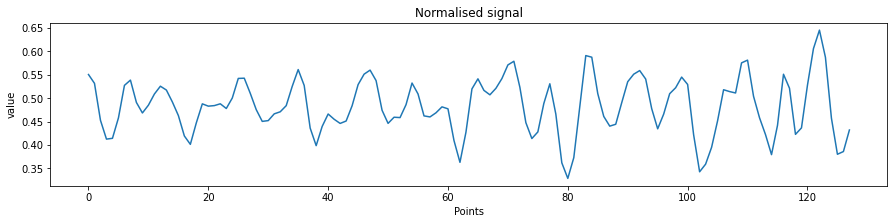

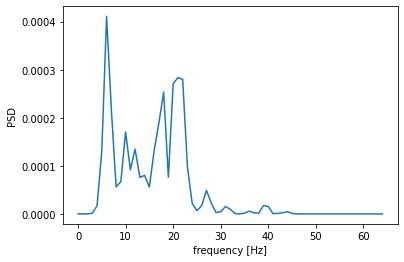

In [ ]:
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(one_data[0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(one_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(normalised_data[0][nth*128:nth*128+128])
plt.title("Normalised signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(normalised_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


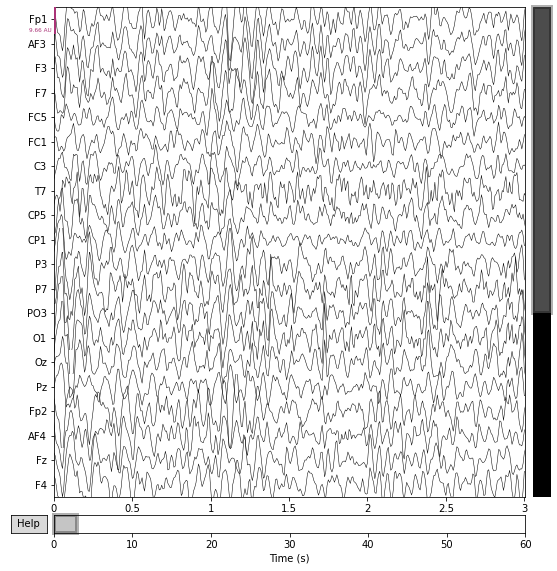

Creating RawArray with float64 data, n_channels=32, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


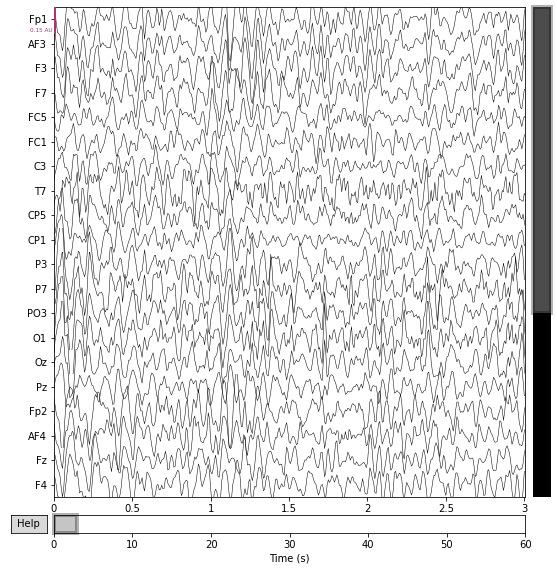

In [ ]:
raw3 = mne.io.RawArray(one_data, info2, first_samp=0, copy='auto', verbose=None);
raw3.plot(duration=3, n_channels=20);

normalised_raw3 = mne.io.RawArray(normalised_data, info2, first_samp=0, copy='auto', verbose=None);
normalised_raw3.plot(duration=3, n_channels=20);

# Compare original signal and reconstructed signal

In [ ]:
autoencoder = keras.models.load_model("/content/gdrive/MyDrive/TPIB/Dataset/Result/autoencoder_model/autoencoder_model_test_fold_1")

In [ ]:
temp = data[:2] # first two trial
data_ = []
for t in temp:
    data_.append(standardise_2D(t, 1))
print(np.amax(data_[0])) # max value
print(np.amin(data_[0])) # min value

8.3196132436574
-7.789838539676193


In [ ]:
data_ = np.array(data_)
data_vector = vector_transform(data_)
print(data_vector.shape)
data_reconstructed_vector = autoencoder.predict(data_vector)
data_reconstructed = inverse_vector_transform(data_reconstructed_vector)
data_reconstructed.shape

(15360, 32)


(2, 32, 7680)

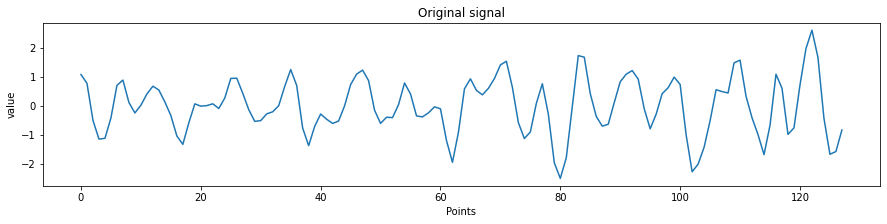

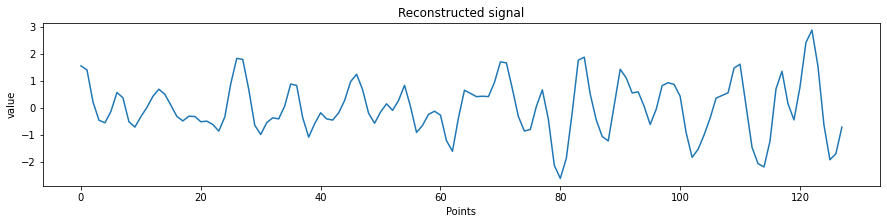

In [ ]:
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(data_[0][0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(data_reconstructed[0][0][nth*128:nth*128+128])
plt.title("Reconstructed signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()